In [50]:
from langgraph.graph import StateGraph,START,END
from langchain_groq import ChatGroq
from typing import TypedDict,Dict, Any,List,Annotated,Literal
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage,HumanMessage
import operator

In [51]:
import os
from pydantic import BaseModel,Field

load_dotenv()
groq_api_key  = os.getenv("GROQ_API_KEY")
if not groq_api_key:
    raise ValueError("GROQ_API_KEY not found in environment")

In [52]:
generator_llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)
evaluator_llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)
optimizer_llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    temperature=0,
    max_tokens=8192,
    api_key=groq_api_key,
    base_url = "https://api.groq.com/openai/v1"
)

In [53]:
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation:Literal["Approved","needs_improvement"]
    feedback:str
    iteration:int
    max_iteration:int

    tweet_history:Annotated[list[str],operator.add]
    feedback_history:Annotated[list[str],operator.add]

    



class evaluation_opt(BaseModel):
    evaluator:Literal["Approved","needs_improvement"] = Field(description="evaluation of tweet content")
    feedback:str = Field(...,description="feedback for the tweet")

evaluator_llm = evaluator_llm.with_structured_output(evaluation_opt)

In [54]:
def generate_tweet(state:TweetState) -> Dict[str,Any]:
    topic = state["topic"]
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{topic}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english

""")
    ]
    tweet = generator_llm.invoke(messages).content

    return {"tweet":tweet,"tweet_history":[tweet]}

def evaluator_tweet(state:TweetState) -> Dict[str,Any]:
    tweet = state["tweet"]
    messages = [
        SystemMessage(content = "You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content = f"""
Evaluate the following tweet:

Tweet: "{tweet}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
    ]
    eval = evaluator_llm.invoke(messages)
    return {"evaluation":eval.evaluator,"feedback":eval.feedback,"feedback_history":[eval.feedback]}

def optimizer_tweet(state:TweetState) -> Dict[str,Any]:
    feedback = state["feedback"]
    tweet = state["tweet"]
    topic = state["topic"]
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{feedback}"

Topic: "{topic}"
Original Tweet:
{tweet}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response = optimizer_llm.invoke(messages).content
    iteration = state["iteration"]+1

    return {"tweet":response,"iteration":iteration,"tweet_history":[response]}


In [55]:
def route_evaluation(state:TweetState):
    if state["evaluation"] == "Approved" or state["iteration"] >= state["max_iteration"]:
        return "Approved"
    else:
        return "needs_improvement"

In [56]:
graph = StateGraph(TweetState)

graph.add_node("generate_tweet",generate_tweet)
graph.add_node("evaluate_tweet",evaluator_tweet)
graph.add_node("optimize_tweet",optimizer_tweet)

graph.add_edge(START,"generate_tweet")
graph.add_edge("generate_tweet","evaluate_tweet")
graph.add_conditional_edges("evaluate_tweet",route_evaluation,{"Approved":END,"needs_improvement":"optimize_tweet"})
graph.add_edge("optimize_tweet","evaluate_tweet")

workflow = graph.compile()

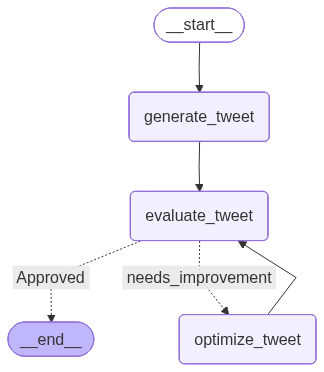

In [57]:
workflow

In [62]:
initial_state = {
    "topic": "who who",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [63]:
result

{'topic': 'who who',
 'tweet': 'Just heard “who\u202fwho” and instantly imagined a boardroom of influencers trying to sound mysterious. Turns out it was my neighbor’s parrot judging my life choices. #WhoWho #BirdsOfAFeather #AdultingIsHard',
 'evaluation': 'Approved',
 'feedback': 'The tweet feels fresh with a quirky parrot twist that most people haven’t seen, delivering a laugh‑worthy mental image of influencers in a boardroom. It’s concise enough for a scroll‑stop, stays under the character limit, and avoids a classic setup‑punchline or Q&A format. Its hashtag combo (#WhoWho #BirdsOfAFeather #AdultingIsHard) gives it shareable appeal, making it likely to get retweets from both humor and pet‑lover audiences.',
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['Just heard “who\u202fwho” and instantly imagined a boardroom of influencers trying to sound mysterious. Turns out it was my neighbor’s parrot judging my life choices. #WhoWho #BirdsOfAFeather #AdultingIsHard'],
 'feedback